Use actual time series tools to investigate covid data

Work up to ARMIA with intervention

In [56]:
import pandas as pd
from covid_project.data_utils import clean_covid_data, clean_policy_data, prep_policy_data, prepare_new_df, prepare_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from tqdm.notebook import tqdm
import warnings

In [2]:
case_data = clean_covid_data()
policy_data = clean_policy_data()

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/data_utils.py:361: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['county'].replace(to_replace=county_match, value='', inplace=True)
/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/data_utils.py:362: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obj

In [3]:
case_data.head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name,new_cases_7day_1e6,new_deaths_7day_1e6
91440,84001001,county,1001,autauga,Alabama,2020-01-22,55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,"autauga, Alabama",0.0,0.0
91441,84001001,county,1001,autauga,Alabama,2020-01-23,55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,"autauga, Alabama",0.0,0.0
91442,84001001,county,1001,autauga,Alabama,2020-01-24,55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,"autauga, Alabama",0.0,0.0
91443,84001001,county,1001,autauga,Alabama,2020-01-25,55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,"autauga, Alabama",0.0,0.0
91444,84001001,county,1001,autauga,Alabama,2020-01-26,55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,"autauga, Alabama",0.0,0.0


In [23]:
case_data['date'].max()

Timestamp('2021-12-30 00:00:00')

In [4]:
policy_data.head()

,state,policy_level,date,policy_type,start_stop,county,fips_code
1,Mississippi,county,2020-07-20,outdoor and recreation,stop,sunflower,28133
3,Missouri,state,2020-06-15,non-essential businesses,stop,statewide,29
5,Georgia,county,2020-04-30,childcare (k-12),stop,fulton,13121
6,Missouri,county,2020-05-31,entertainment,stop,jackson,29095
7,Missouri,state,2021-08-31,mask requirement,stop,statewide,29


# part 1 - start by focusing on one county

In [16]:
case_df = case_data[(case_data['county'] == 'fulton') & (case_data['state']=='Georgia')]['new_cases_1e6']
case_df

603504      0.00
603505      0.00
603506      0.00
603507      0.00
603508      0.00
           ...  
604208      0.00
604209    492.61
604210    169.98
604211    265.58
604212    292.20
Name: new_cases_1e6, Length: 709, dtype: float64

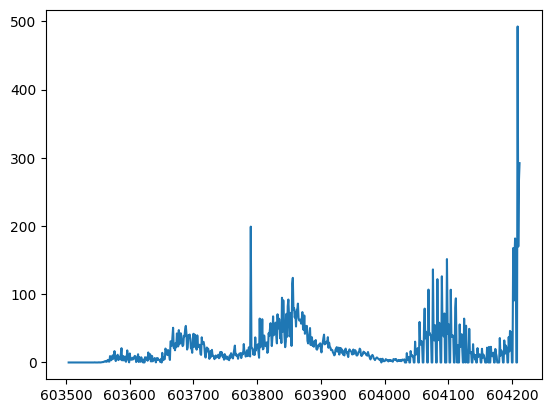

In [17]:
plt.plot(case_df)

## ACH plot

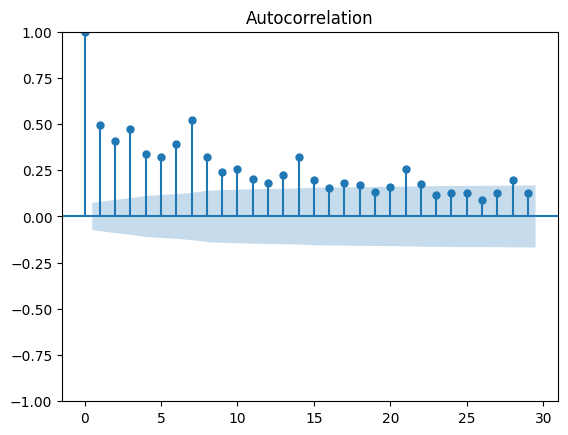

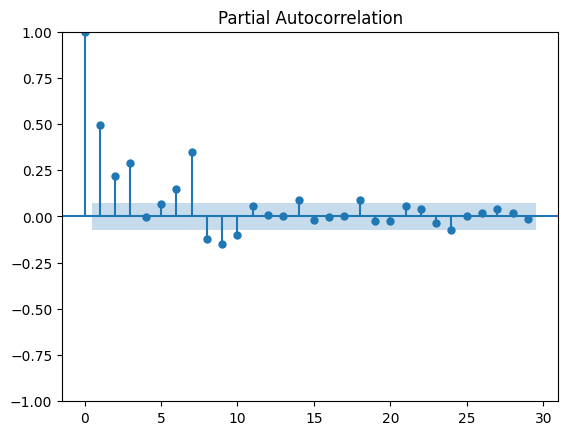

In [21]:
_ = plot_acf(case_df)
_ = plot_pacf(case_df)

looks like we do have some auto-correlation, so not stationary

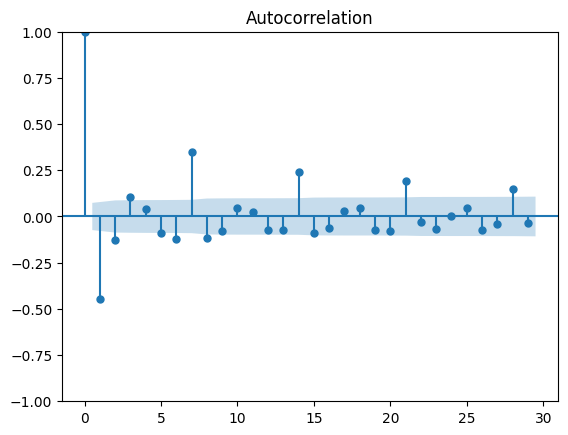

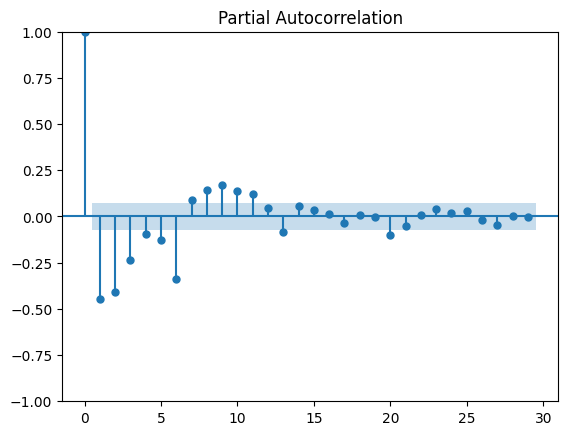

In [22]:
case_df_diff = case_df.diff().dropna()
_ = plot_acf(case_df_diff)
_ = plot_pacf(case_df_diff)

## Try running ARIMA straight from statsmodels

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
model = ARIMA(case_df).fit()
print(model.params)


const       21.859290
sigma2    1189.787697
dtype: float64


/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Now try running ARIMA with info about policies

In [30]:
case_data = clean_covid_data()
policy_data = clean_policy_data()

policy_dict = {
    'aca special enrollment period' : 'medical', 
    'agriculture' : 'agriculture',
    'allow audio only telehealth' : 'medical', 
    'alternative care facilities' : 'medical', 
    'bars' : 'entertainement', 
    'childcare (k-12)' : 'childcare', 
    'colleges & universities' : 'education',
    'construction' : 'construction', 
    'day camps/overnight camps' : 'camps', 
    'day care' : 'childcare',
    'education' : 'education', 
    'election' : 'election', 
    'entertainment' : 'entertainment', 
    'executive order' : 'executive order',
    'expand medicaid telehealth coverage' : 'medical', 
    'food and drink' : 'entertainment',
    'froze mortgage payments' : 'housing', 
    'gatherings' : 'gatherings', 
    'grace period / security deposit for rent' : 'housing', 
    'graduation' : 'graduation',
    'graduation ceremony guidelines' : 'graduation', 
    'gyms' : 'gyms', 
    'health risk status' : 'medical',
    'higher education' : 'education', 
    'houses of worship' : 'houses of worship', 
    'libraries' : 'education',
    'mandate face masks in businesses' : 'mask mandate',
    'mandate face masks in public spaces' : 'mask mandate', 
    'manufacturing' : 'manufacturing',
    'mask requirement' : 'mask mandate', 
    'medical' : 'medical', 
    'modify medicaid requirements' : 'medical',
    'museums' : 'education', 
    'non-essential businesses' : 'non-essential businesses', 
    'nursing home visitations' : 'nursing homes',
    'nursing homes' : 'nursing homes', 
    'order freezing utility shut offs' : 'housing',
    'outdoor and recreation' : 'outdoor and recreation', 
    'personal care' : 'personal care', 
    'public gatherings' : 'gatherings',
    'public health advisory system' : 'medical', 
    'quarantine' : 'shelter in place',
    'residential overnight camps' : 'camps',
    'resumed elective medical procedures' : 'medical', 
    'shelter in place' : 'shelter in place',
    'state of emergency' : 'state of emergency', 
    'state of emergency/funds' : 'state of emergency',
    'stop enforcement of evictions' : 'housing', 
    'stop initiation of evictions' : 'housing',
    'suspend elective dental procedures' : 'medical', 
    'training jobs' : 'training jobs', 
    'travel' : 'travel',
    'traveler from out of state' : 'travel', 
    'updated guidelines' : 'updated guidelines',
    'wholesale trade' : 'wholesale trade',
}

policy_data_prepped = prep_policy_data(
    policy_data=policy_data,
    policy_dict=policy_dict,
    min_samples=3)

all_policies = policy_data_prepped['full_policy'].unique()

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/data_utils.py:792: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  proc_policy_data['policy_type'].replace(to_replace=key, value=policy_dict[key], inplace=True)


In [32]:
all_policies

array(['outdoor and recreation - stop - county',
       'non-essential businesses - stop - state',
       'childcare - stop - county', 'entertainment - stop - county',
       'mask mandate - stop - state',
       'non-essential businesses - stop - county',
       'personal care - stop - state', 'shelter in place - stop - county',
       'gyms - stop - state', 'outdoor and recreation - stop - state',
       'houses of worship - stop - state',
       'houses of worship - stop - county', 'childcare - stop - state',
       'shelter in place - stop - state', 'entertainment - stop - state',
       'manufacturing - stop - state', 'manufacturing - stop - county',
       'mask mandate - stop - county', 'personal care - stop - county',
       'executive order - stop - state', 'manufacturing - start - state',
       'mask mandate - start - county', 'entertainment - start - county',
       'childcare - start - state', 'childcare - start - county',
       'gyms - start - state', 'houses of worship 

In [34]:
new_df = prepare_new_df(case_data)

In [35]:
new_df

info                                             \
        location_type    state   county       date new_cases_1e6   
91440          county  Alabama  autauga 2020-01-22          0.00   
91441          county  Alabama  autauga 2020-01-23          0.00   
91442          county  Alabama  autauga 2020-01-24          0.00   
91443          county  Alabama  autauga 2020-01-25          0.00   
91444          county  Alabama  autauga 2020-01-26          0.00   
...               ...      ...      ...        ...           ...   
3684593        county  Wyoming   weston 2021-12-26          0.00   
3684594        county  Wyoming   weston 2021-12-27         14.08   
3684595        county  Wyoming   weston 2021-12-28         28.17   
3684596        county  Wyoming   weston 2021-12-29         42.25   
3684597        county  Wyoming   weston 2021-12-30         28.17   

                                                               
        new_deaths_1e6 new_cases_7day_1e6 new_deaths_7day_1e6  
91440              0.0           0.000000                 0.0  
91441              0.0           0.000000                 0.0  
91442              0.0           0.000000                 0.0  
91443              0.0           0.000000                 0.0  
91444              0.0           0.000000                 0.0  
...                ...                ...                 ...  
3684593            0.0          20.140845                 0.0  
3684594            0.0          12.112676                 0.0  
3684595            0.0          12.112676                 0.0  
3684596            0.0          18.169014                 0.0  
3684597            0.0          16.056338                 0.0  

[2228387 rows x 8 columns]

In [36]:
bins_list = [(0, 14), (15, 999)]
data = prepare_data(
    case_data=case_data,
    policy_data_prepped=policy_data_prepped,
    policy_name='shelter in place - start - state',
    bins_list=bins_list,
    pbar=True,
    new_df=new_df)

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/data_utils.py:898: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df = new_df.fillna(0)


  0%|          | 0/47 [00:00<?, ?it/s]

In [45]:
test_df = pd.read_csv("./data/single_policy_bins/" +\
                      os.listdir("./data/single_policy_bins/")[0],
                     index_col=0, header=1)
test_df = test_df[(test_df['state']=='Georgia') & (test_df['county'] == 'fulton')]
test_df

,location_type,state,county,date,new_cases_1e6,new_deaths_1e6,new_cases_7day_1e6,new_deaths_7day_1e6,0-14,15-999
603504,county,Georgia,fulton,2020-01-22,0.00,0.00,0.000000,0.000000,0,0
603505,county,Georgia,fulton,2020-01-23,0.00,0.00,0.000000,0.000000,0,0
603506,county,Georgia,fulton,2020-01-24,0.00,0.00,0.000000,0.000000,0,0
603507,county,Georgia,fulton,2020-01-25,0.00,0.00,0.000000,0.000000,0,0
603508,county,Georgia,fulton,2020-01-26,0.00,0.00,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...
604208,county,Georgia,fulton,2021-12-26,0.00,0.00,107.530859,0.209413,0,1
604209,county,Georgia,fulton,2021-12-27,492.61,0.59,153.942355,0.251492,0,1
604210,county,Georgia,fulton,2021-12-28,169.98,0.49,165.280037,0.251492,0,1
604211,county,Georgia,fulton,2021-12-29,265.58,0.20,181.356921,0.251492,0,1


In [48]:
model = ARIMA(
    test_df['new_cases_1e6'],
    exog = test_df[['0-14', '15-999']]
).fit()

/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
model.aic

6983.47888120287

In [59]:
results = []
params = []

for p in range(10):
    for d in range(10):
        for q in range(10):
            params.append((p, d, q))

results = []
for param_set in tqdm(params):

    p, d, q = param_set
    with warnings.catch_warnings(action='ignore'):
        try:
            model = ARIMA(
                test_df['new_cases_1e6'].values,
                exog = test_df[['0-14', '15-999']].values,
                order = (p,d,q),
            ).fit()
            
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'aic': model.aic,
                'bic': model.bic,})
        except Exception as e:
            print("ERROR! params = {}, {}, {}".format(p, d, q))

        

  0%|          | 0/1000 [00:00<?, ?it/s]

ERROR! params = 1, 7, 5
ERROR! params = 1, 8, 3
ERROR! params = 1, 8, 9
ERROR! params = 1, 9, 8
ERROR! params = 2, 9, 3
ERROR! params = 3, 6, 6
ERROR! params = 3, 7, 3
ERROR! params = 3, 7, 4
ERROR! params = 3, 7, 7
ERROR! params = 3, 7, 9
ERROR! params = 3, 9, 7
ERROR! params = 4, 5, 8
ERROR! params = 4, 8, 6
ERROR! params = 4, 9, 4
ERROR! params = 5, 6, 3
ERROR! params = 5, 7, 7
ERROR! params = 5, 8, 3
ERROR! params = 5, 8, 6
ERROR! params = 6, 5, 2
ERROR! params = 6, 8, 4
ERROR! params = 6, 9, 0
ERROR! params = 6, 9, 1
ERROR! params = 6, 9, 9
ERROR! params = 7, 6, 4
ERROR! params = 7, 6, 8
ERROR! params = 7, 7, 3
ERROR! params = 7, 8, 8
ERROR! params = 7, 9, 1
ERROR! params = 7, 9, 7
ERROR! params = 8, 5, 2
ERROR! params = 8, 5, 4
ERROR! params = 8, 7, 3
ERROR! params = 8, 8, 1
ERROR! params = 9, 5, 4
ERROR! params = 9, 8, 5


In [61]:
import json

with open('./data/dev_arima_results.json', 'w') as f:
    json.dump(results, f)